In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from flask import Flask, jsonify

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.orm import scoped_session, sessionmaker

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# sel = [Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
sel = [func.strftime("%Y", Measurement.date), 
                     func.strftime("%m", Measurement.date), func.strftime("%d", Measurement.date)]
latest_dt = session.query(*sel).order_by(Measurement.date.desc()).first()
latest_year = int(latest_dt[0])
latest_month = int(latest_dt[1])
latest_day = int(latest_dt[2])

In [11]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = dt.date(latest_year, latest_month, latest_day)
last_year = latest_date - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
stmt = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= latest_date).\
    filter(Measurement.date >= last_year).statement
lastyrdata_df = pd.read_sql_query(stmt, session.bind)
lastyrdata_df =  lastyrdata_df[np.isfinite(lastyrdata_df['prcp'])]
lastyrdata_df['date'] = pd.to_datetime(lastyrdata_df['date'])
lastyrdata_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
lastyrdata_df = lastyrdata_df.set_index('date')
lastyrdata_df.head()


,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [15]:
# lastyrdata_df = lastyrdata_df.reset_index()
lastyrdata_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


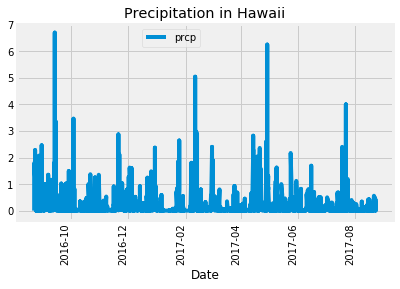

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
lastyrdata_df.plot()
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
# plt.ylabel('precipitation')
plt.legend('pecipitation')
plt.legend(bbox_to_anchor=(0.5, 1.00))
plt.xticks(rotation='90')
plt.show()

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastyrdata_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).count()
stations

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_cnt = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations_cnt

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
station_stats = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()
station_stats

[(54.0, 85.0, 71.66378066378067)]

In [21]:

station_maxtemp = session.query(Measurement.station, func.max(Measurement.tobs)).all()
station_maxtemp

[('USC00519397', 87.0)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt = session.query(Measurement.tobs).\
                            filter(Measurement.station == 'USC00519281').\
                            filter(Measurement.date <= latest_date).\
                            filter(Measurement.date >= last_year).statement
tobs_result = pd.read_sql_query(stmt, session.bind)
tobs_result.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


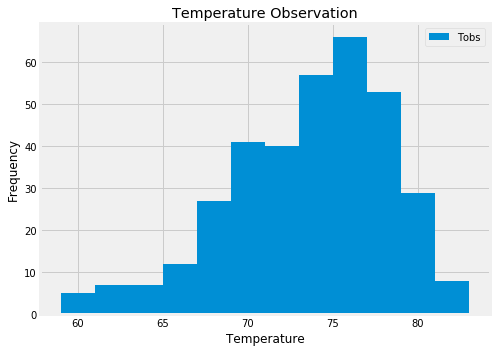

In [23]:
plt.figure(figsize=[7, 5])
plt.hist(tobs_result['tobs'], bins=12)
plt.xlabel("Temperature")
plt.ylabel('Frequency')
plt.legend(["Tobs"])
plt.title('Temperature Observation')
plt.savefig("temperature_observation-Histogram.png")
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
destination_temp = calc_temps('2017-01-01', '2017-01-08')
destination_temp
tAvg = destination_temp[0][1]
tMax = destination_temp[0][2] 
tMin = destination_temp[0][0]
print(tAvg)
print(tMax)
print(tMin)

68.27659574468085
74.0
60.0


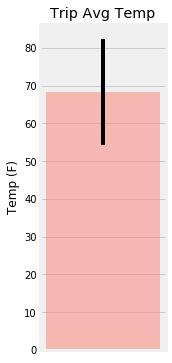

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,6))
plt.bar(0, tAvg, yerr=[tMax-tMin], color='salmon', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
# plt.ylim(60)
plt.savefig("Trip Avg Temp.png")
plt.show()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, Station.longitude,
       Station.elevation, func.avg(Measurement.prcp)]
trip_prcp = session.query(*sel).filter(Measurement.station == Station.station).\
            filter(Measurement.date <= '2017-01-08').\
            filter(Measurement.date >= '2017-01-01').\
            group_by(Measurement.station).\
            order_by(func.avg(Measurement.prcp).desc()).all()
trip_prcp


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
